In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from google.colab import files

# datasets
trip_data = pd.read_excel('/content/drive/MyDrive/FLEXI_trip_data.xls')  
bus_stops = pd.read_excel('/content/drive/MyDrive/FLEXI_bus_stops.xls')  

# Filter the trip data to include only rows with Pickup ID and Dropoff ID <= 69, and only completed trips
trip_data_cleaned = trip_data[(trip_data['Pickup ID'] <= 69) &
                              (trip_data['Dropoff ID'] <= 69) &
                              (trip_data['Passenger status'] == 'Trip completed')]

# Rename 'index' column in bus_stops to 'Stop ID' for easier merging
bus_stops.rename(columns={'index': 'Stop ID'}, inplace=True)

# Merged trip data with bus stops to get pickup location details
pickup_merged_data = trip_data_cleaned.merge(bus_stops, left_on='Pickup ID', right_on='Stop ID', how='left')
pickup_merged_data.rename(columns={'latitude': 'pickup_latitude', 'longitude': 'pickup_longitude'}, inplace=True)

# Merged again to get dropoff location details
final_data = pickup_merged_data.merge(bus_stops, left_on='Dropoff ID', right_on='Stop ID', how='left')
final_data.rename(columns={'latitude': 'dropoff_latitude', 'longitude': 'dropoff_longitude'}, inplace=True)

# Select only the relevant columns for the final dataset
final_data = final_data[['Pickup ID', 'pickup_latitude', 'pickup_longitude',
                         'Dropoff ID', 'dropoff_latitude', 'dropoff_longitude',
                         'Actual Pickup Time', 'Actual Dropoff Time']]

# Define heatmap_data by combining pickup and dropoff locations
heatmap_data = pd.concat([
    final_data[['pickup_latitude', 'pickup_longitude']].rename(columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'}),
    final_data[['dropoff_latitude', 'dropoff_longitude']].rename(columns={'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude'})
])

# Ensure latitude and longitude precision to six decimal places
heatmap_data['latitude'] = heatmap_data['latitude'].round(6)
heatmap_data['longitude'] = heatmap_data['longitude'].round(6)

# Verify data precision by printing the first few rows
print("Sample of latitude and longitude with full precision:")
print(heatmap_data[['latitude', 'longitude']].head(10))

# Prepare heatmap data as a list of [latitude, longitude] pairs
heat_data = heatmap_data[['latitude', 'longitude']].values.tolist()



Sample of latitude and longitude with full precision:
    latitude  longitude
0  48.994215  11.461103
1  49.041112  11.471240
2  49.032173  11.476295
3  49.033832  11.471982
4  48.976827  11.559612
5  49.010337  11.502283
6  49.041112  11.471240
7  49.041112  11.471240
8  48.976207  11.491877
9  48.992168  11.377365


In [ ]:
# Check after merging trip_data_cleaned with bus_stops for pickup details
print("\nAfter merging for pickup details (pickup_merged_data):")
print(pickup_merged_data.head())

# Check after merging for dropoff details to create final_data
print("\nAfter merging for dropoff details (final_data):")
print(final_data.head())

# Verify columns in final_data to confirm all expected columns are present
print("\nColumns in final_data:")
print(final_data.columns)



After merging for pickup details (pickup_merged_data):
   Booking ID     Status Passenger status  Passengers  Pickup ID  Dropoff ID  \
0      253782  Validated   Trip completed           2         40          21   
1      251869  Validated   Trip completed           3         27           0   
2      251083  Validated   Trip completed           1         20           9   
3      253916  Validated   Trip completed           2         19           0   
4      251100  Validated   Trip completed           1         50          38   

   Actual Pickup Time Actual Dropoff Time  Stop ID                       name  \
0 2024-09-01 09:14:00 2024-09-01 09:25:00       40  Irfersdorf, Am Kirchplatz   
1 2024-09-01 09:54:00 2024-09-01 10:06:00       27          Beilngries, Hafen   
2 2024-09-01 10:39:00 2024-09-01 10:46:00       20            Beilngries, ZOB   
3 2024-09-01 10:36:00 2024-09-01 10:52:00       19    Beilngries, Ringstrasse   
4 2024-09-01 11:23:00 2024-09-01 11:34:00       50    Wolf

In [ ]:
# Group by rounded coordinates to see how many points fall in each approximate area
# This will give a sense of clustering by rounding coordinates to two decimal places
rounded_coords = heatmap_data.copy()
rounded_coords['latitude'] = rounded_coords['latitude'].round(6)
rounded_coords['longitude'] = rounded_coords['longitude'].round(6)

# Count occurrences of each coordinate pair to see if there's clustering
print("Data distribution by rounded coordinates:")
print(rounded_coords.value_counts(['latitude', 'longitude']).head(20))


Data distribution by rounded coordinates:
latitude   longitude
48.992168  11.377365    691
49.036378  11.470632    264
49.033832  11.471982    249
49.035227  11.467885    201
49.038150  11.451488    195
49.017505  11.404733    180
49.033525  11.475793    160
49.035103  11.474083    152
49.036912  11.471075    146
48.994215  11.461103    122
49.010337  11.502283    121
48.976827  11.559612    107
49.068532  11.455142     92
48.992498  11.363953     85
49.000562  11.382790     85
49.032928  11.479163     70
49.041112  11.471240     66
49.005142  11.445253     58
49.048472  11.431715     55
49.031608  11.461872     52
Name: count, dtype: int64


In [ ]:
heatmap_data = pd.concat([
    final_data[['pickup_latitude', 'pickup_longitude']].rename(columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'}),
    final_data[['dropoff_latitude', 'dropoff_longitude']].rename(columns={'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude'})
])

# Save heatmap data to CSV
heatmap_data.to_csv("heatmap_data.csv", index=False)
print("Saved heatmap data to heatmap_data.csv")


Saved heatmap data to heatmap_data.csv


In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Sample data with precise latitude, longitude, and frequency counts
location_counts = pd.DataFrame({
    'latitude': [48.992168, 49.036378, 49.033832, 49.035227, 49.038150, 49.017505,
                 49.033525, 49.035103, 49.036912, 48.994215, 49.010337, 48.976827,
                 49.068532, 48.992498, 49.000562, 49.032928, 49.041112, 49.005142,
                 49.048472, 49.031608],
    'longitude': [11.377365, 11.470632, 11.471982, 11.467885, 11.451488, 11.404733,
                  11.475793, 11.474083, 11.471075, 11.461103, 11.502283, 11.559612,
                  11.455142, 11.363953, 11.382790, 11.479163, 11.471240, 11.445253,
                  11.431715, 11.461872],
    'count': [691, 264, 249, 201, 195, 180, 160, 152, 146, 122, 121, 107, 92, 85, 85, 70, 66, 58, 55, 52]
})

# Prepare heatmap data with weights based on frequency count
heat_data = location_counts[['latitude', 'longitude', 'count']].values.tolist()

# Initialize map centered specifically around the main data cluster
m = folium.Map(location=[49.0, 11.45], zoom_start=12)

# Step 1: Add markers to preview specific coordinates for accuracy
# Temporary markers to confirm correct locations
for idx, row in location_counts.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Count: {row['count']}"
    ).add_to(m)




# Step 4: Add the weighted heatmap layer
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m)

# Display the map
m


# **TIME AGGREGATION**

In [ ]:
final_data['Actual Pickup Time'] = pd.to_datetime(final_data['Actual Pickup Time'])
final_data['Actual Dropoff Time'] = pd.to_datetime(final_data['Actual Dropoff Time'])


In [ ]:
hourly_data = final_data.groupby(final_data['Actual Pickup Time'].dt.hour).size().reset_index(name='demand_count')
hourly_data.columns = ['hour_of_day', 'demand_count']  

print("Hourly Aggregation Result:")
print(hourly_data.head())


Hourly Aggregation Result:
   hour_of_day  demand_count
0            5            79
1            6            77
2            7           121
3            8           124
4            9            93


In [ ]:
# Group by pickup date to find daily demand
daily_data = final_data.groupby(final_data['Actual Pickup Time'].dt.date).size().reset_index(name='demand_count')
daily_data.columns = ['date', 'demand_count']  # Rename columns for clarity

print("Daily Aggregation Result:")
print(daily_data.head())


Daily Aggregation Result:
         date  demand_count
0  2024-09-01            26
1  2024-09-02            50
2  2024-09-03            61
3  2024-09-04            66
4  2024-09-05            70


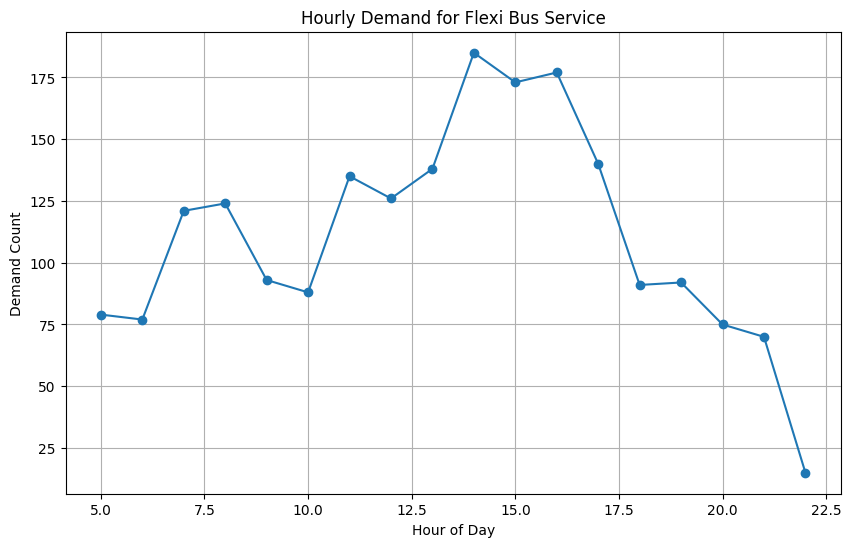

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourly_data['hour_of_day'], hourly_data['demand_count'], marker='o')
plt.title('Hourly Demand for Flexi Bus Service')
plt.xlabel('Hour of Day')
plt.ylabel('Demand Count')
plt.grid()
plt.show()


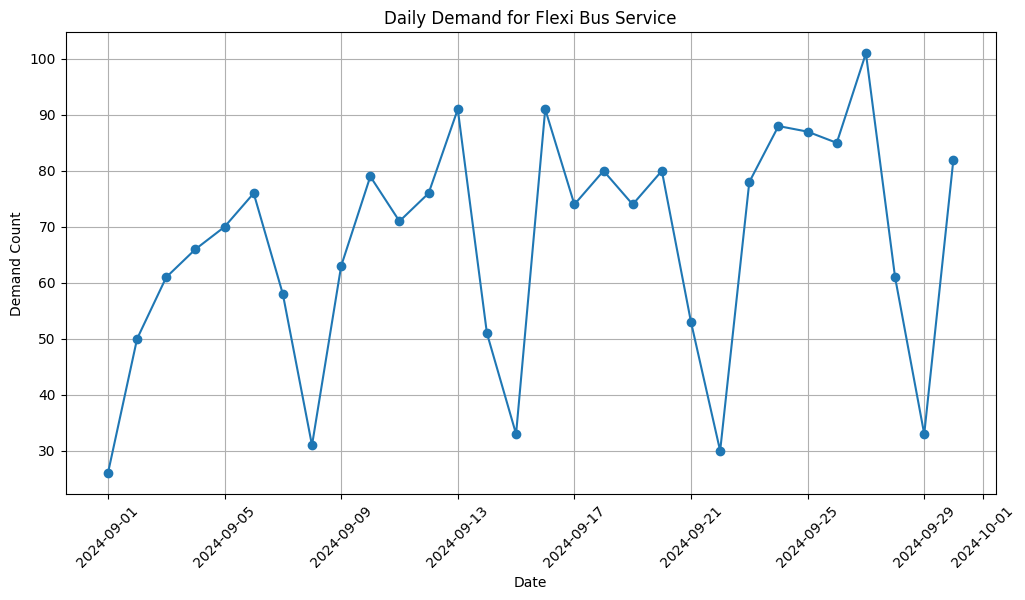

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data['date'], daily_data['demand_count'], marker='o')
plt.title('Daily Demand for Flexi Bus Service')
plt.xlabel('Date')
plt.ylabel('Demand Count')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [ ]:
!pip install keplergl

In [ ]:
import pandas as pd

# Assuming final_data is already prepared with latitude, longitude, and timestamp information

# Concatenate pickup and dropoff data into a single DataFrame for visualization
kepler_data = pd.concat([
    final_data[['pickup_latitude', 'pickup_longitude', 'Actual Pickup Time']].rename(
        columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude', 'Actual Pickup Time': 'timestamp'}),
    final_data[['dropoff_latitude', 'dropoff_longitude', 'Actual Dropoff Time']].rename(
        columns={'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude', 'Actual Dropoff Time': 'timestamp'})
])

# Convert timestamp to a uniform datetime format for Kepler.gl compatibility
kepler_data['timestamp'] = pd.to_datetime(kepler_data['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Preview the data
print(kepler_data.head())


    latitude  longitude             timestamp
0  48.994215  11.461103  2024-09-01T09:14:00Z
1  49.041112  11.471240  2024-09-01T09:54:00Z
2  49.032173  11.476295  2024-09-01T10:39:00Z
3  49.033832  11.471982  2024-09-01T10:36:00Z
4  48.976827  11.559612  2024-09-01T11:23:00Z


In [ ]:
from keplergl import KeplerGl

# inir a Kepler.gl map and add the prepared data
map_1 = KeplerGl(height=600)  # Set map height for better display
map_1.add_data(data=kepler_data, name="Flexi Bus Demand")

# Display the map inline (for Jupyter/Colab interactive sessions)
map_1


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Flexi Bus Demand': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

In [ ]:
# Save the map to an HTML file for offline viewing
map_1.save_to_html(file_name="kepler_flexi_demand_map.html")

# Download the HTML file in Colab for offline access
from google.colab import files
files.download("kepler_flexi_demand_map.html")


Map saved to kepler_flexi_demand_map.html!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# FORECASTING


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# Group data by location and hourly intervals
kepler_data['timestamp'] = pd.to_datetime(kepler_data['timestamp'])
kepler_data.set_index('timestamp', inplace=True)
hourly_data = kepler_data.groupby([pd.Grouper(freq='H'), 'latitude', 'longitude']).size().reset_index(name='demand_count')

# Feature engineering
hourly_data['hour'] = hourly_data['timestamp'].dt.hour
hourly_data['day_of_week'] = hourly_data['timestamp'].dt.dayofweek
hourly_data['is_weekend'] = hourly_data['day_of_week'].isin([5, 6]).astype(int)

# Shift to create lag features (previous demand counts)
hourly_data['lag_1'] = hourly_data.groupby(['latitude', 'longitude'])['demand_count'].shift(1).fillna(0)
hourly_data['lag_2'] = hourly_data.groupby(['latitude', 'longitude'])['demand_count'].shift(2).fillna(0)
hourly_data['rolling_mean_3'] = hourly_data.groupby(['latitude', 'longitude'])['demand_count'].transform(lambda x: x.rolling(3).mean()).fillna(0)

# Define features and target
features = ['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'rolling_mean_3']
X = hourly_data[features]
y = hourly_data['demand_count']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Now you can use model.predict() to forecast demand for new data


<ipython-input-31-d4bef6e3ad84>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = kepler_data.groupby([pd.Grouper(freq='H'), 'latitude', 'longitude']).size().reset_index(name='demand_count')


Mean Absolute Error: 0.029441483060886047


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Define forecast horizon and locations
forecast_hours = 24  # Forecasting for the next 24 hours
base_time = pd.to_datetime("2024-11-02 00:00:00")  # Starting point for forecast (adjust as needed)
locations = [(48.7665, 11.4254)]  # Replace with actual latitude, longitude pairs for each location

# Create future timestamps and replicate for each location
future_data = []
for lat, lon in locations:
    for hour in range(forecast_hours):
        timestamp = base_time + timedelta(hours=hour)
        future_data.append([timestamp, lat, lon])

future_df = pd.DataFrame(future_data, columns=['timestamp', 'latitude', 'longitude'])

# Feature engineering for future data
future_df['hour'] = future_df['timestamp'].dt.hour
future_df['day_of_week'] = future_df['timestamp'].dt.dayofweek
future_df['is_weekend'] = future_df['day_of_week'].isin([5, 6]).astype(int)

# Use last known demand values to create lag features
# Adjust to use predictions if forecasting multiple steps ahead
last_known_demand = 5  # Example value; replace with actual data
future_df['lag_1'] = last_known_demand  # Adjust if predicting step-by-step
future_df['lag_2'] = last_known_demand
future_df['rolling_mean_3'] = last_known_demand

# Select the same feature columns as in training
features = ['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'rolling_mean_3']
X_future = future_df[features]

# Predict demand
future_df['predicted_demand'] = model.predict(X_future)

# Preview the forecasted demand
print(future_df[['timestamp', 'latitude', 'longitude', 'predicted_demand']])


             timestamp  latitude  longitude  predicted_demand
0  2024-11-02 00:00:00   48.7665    11.4254              3.63
1  2024-11-02 01:00:00   48.7665    11.4254              3.63
2  2024-11-02 02:00:00   48.7665    11.4254              3.63
3  2024-11-02 03:00:00   48.7665    11.4254              3.63
4  2024-11-02 04:00:00   48.7665    11.4254              3.63
5  2024-11-02 05:00:00   48.7665    11.4254              3.63
6  2024-11-02 06:00:00   48.7665    11.4254              3.63
7  2024-11-02 07:00:00   48.7665    11.4254              3.64
8  2024-11-02 08:00:00   48.7665    11.4254              3.64
9  2024-11-02 09:00:00   48.7665    11.4254              3.71
10 2024-11-02 10:00:00   48.7665    11.4254              3.70
11 2024-11-02 11:00:00   48.7665    11.4254              3.63
12 2024-11-02 12:00:00   48.7665    11.4254              3.63
13 2024-11-02 13:00:00   48.7665    11.4254              3.71
14 2024-11-02 14:00:00   48.7665    11.4254              3.70
15 2024-

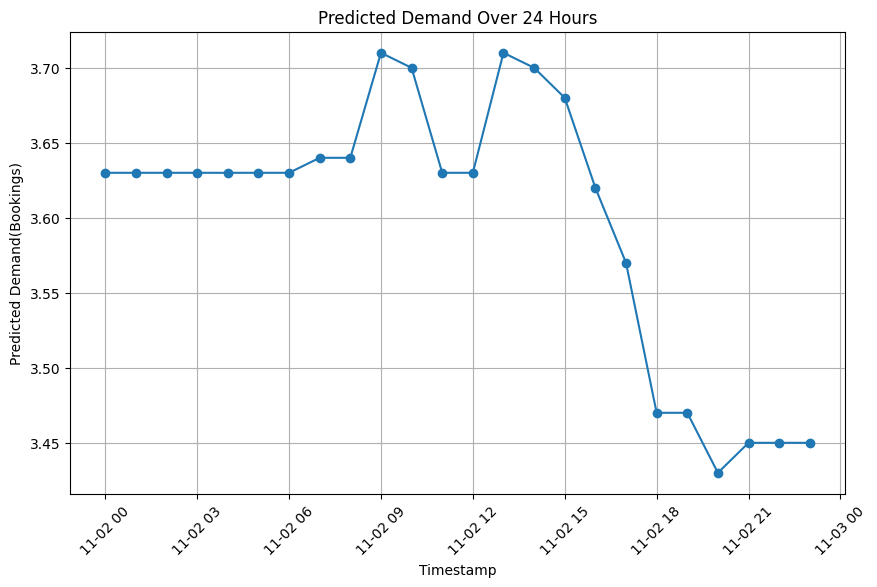

In [ ]:
import matplotlib.pyplot as plt

# Plot the forecasted demand over the next 24 hours
plt.figure(figsize=(10, 6))
plt.plot(future_df['timestamp'], future_df['predicted_demand'], marker='o')
plt.title('Predicted Demand Over 24 Hours')
plt.xlabel('Timestamp')
plt.ylabel('Predicted Demand(Bookings)')
plt.xticks(rotation=45)
plt.grid()
plt.show()
